### Drzewa decyzyjne

In [41]:
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()  #  plots :)

#### scikit-learn

array([0.58561555, 0.41438445])

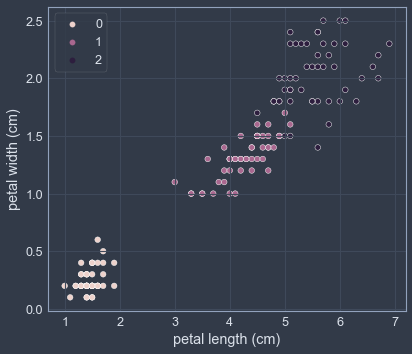

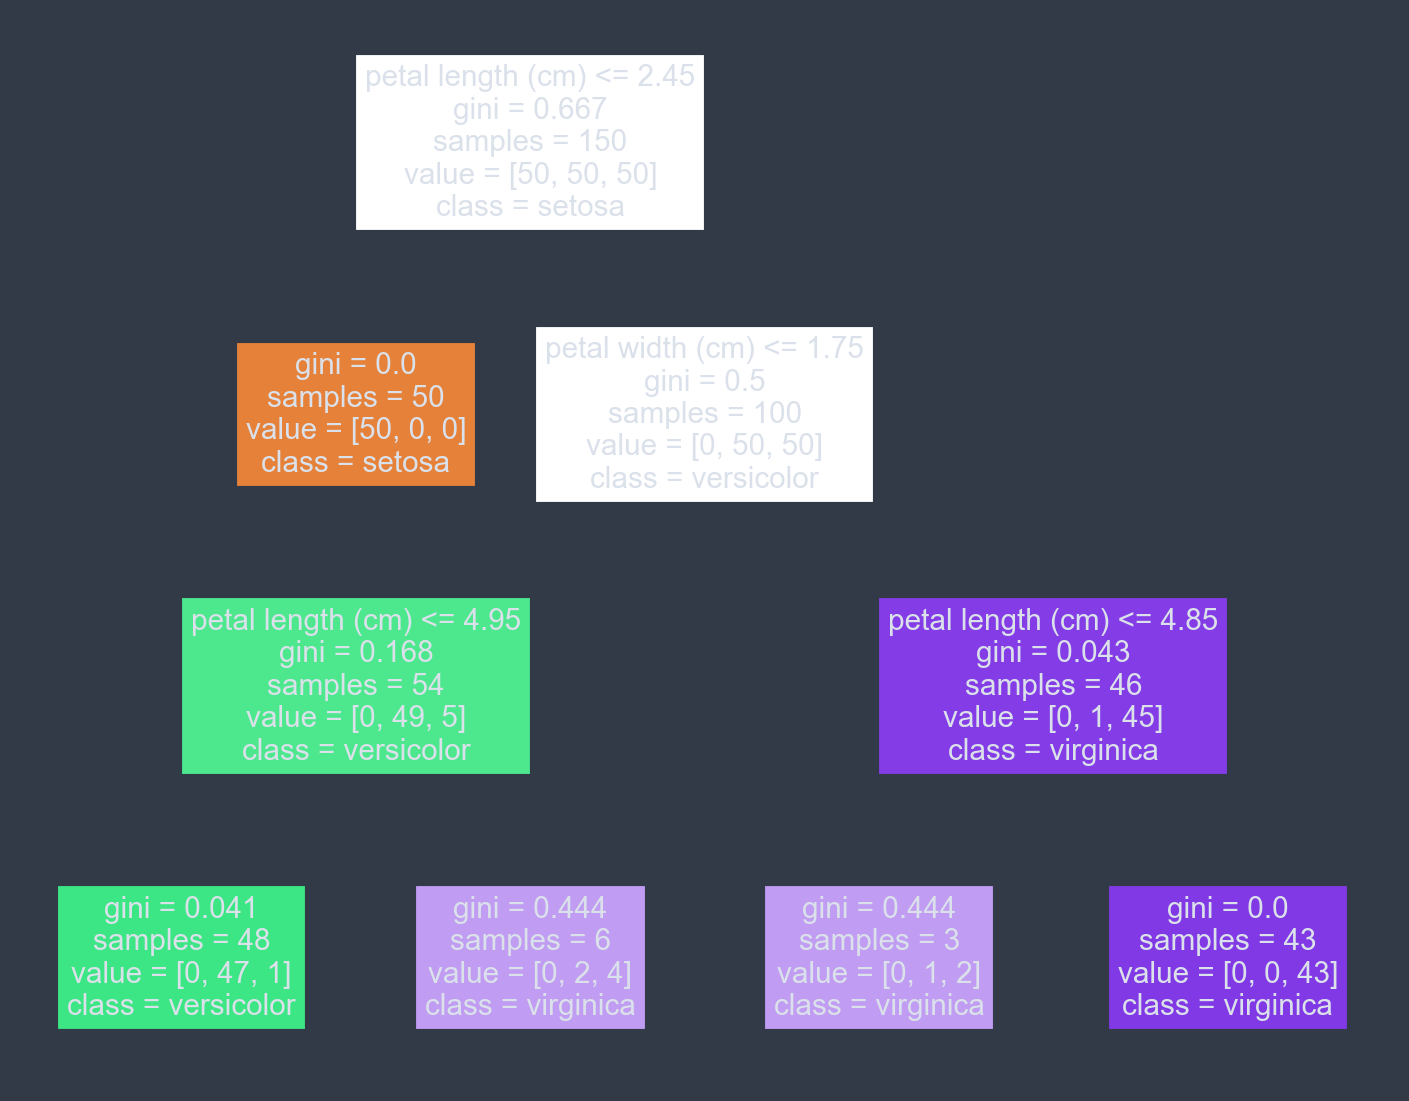

In [42]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np


iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(random_state=42, max_depth=3)
tree_clf.fit(X, y)

display(tree_clf.feature_importances_)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf, 
                   feature_names=iris.feature_names[2:],  
                   class_names=iris.target_names,
                   filled=True)

In [43]:
from collections import defaultdict


def impurity(labels):
    distinct_classes = set(labels)  # does not matter if more classes appears in dataset than for calculations here - these classes would have 0 influence on result
    d = defaultdict(int)
    
    for distinct_class in distinct_classes:
        for label in labels:
            if label == distinct_class:
                d[distinct_class] += 1
        
    return 1 - sum((n_labels_in_class / len(labels)) ** 2 for _, n_labels_in_class in d.items())

def test_impurity():
    display(impurity([1, 1, 1, 1, 2, 2, 2, 2]))
    display(impurity([1, 1, 2, 2, 2, 2, 2, 2]))
    display(impurity([1, 1, 2, 2, 2, 2, 3, 3]))
    display(impurity([1, 2]))
    display(impurity([1, 1]))
    display(impurity([2, 2]))

In [44]:
test_impurity()

0.5

0.375

0.625

0.5

0.0

0.0

In [45]:
### CART


class J_cost:
    def __init__(self, k, t_k, cost, G_left, G_right):
        self.k = k
        self.t_k = t_k
        self.cost = cost
        self.G_left, self.G_right = G_left, G_right
    
    def __lt__(self, other):
        return self.cost < other.cost


def CART_iteration(node):
    J_s = []
    feature_nums = [0, 1]

    m = len(y)

    df = node.df
    for k in feature_nums:
        for t_k in np.linspace(0, 10):
            left = df.loc[df[f"X{k}"] < t_k]
            right = df.loc[df[f"X{k}"] >= t_k]
            m_left = len(left)
            m_right = len(right)
            G_left = impurity(left["target"].to_numpy())
            G_right = impurity(right["target"].to_numpy())
            cost = m_left / m * G_left + m_right / m * G_right
            J_s.append(J_cost(k, t_k, cost, G_left, G_right))
    return J_s
        
def test_J_sorting():
    display([item.cost for item in J_s])
    display([item.cost for item in sorted(J_s)])

In [67]:
class Node:
    def __init__(self, df):
        self.df = df

        
class Parent:
    def __init__(self, left_node, right_node, best_J):
        self.left_node = left_node
        self.right_node = right_node
        self.best_J = best_J

        
def node_split(J_s, df):
    J_s_sorted = sorted(J_s)
    best_J = J_s_sorted[0] 
    k = best_J.k
    t_k = best_J.t_k
    left_node = Node(df.loc[df[f"X{k}"] < t_k])
    right_node = Node(df.loc[df[f"X{k}"] >= t_k])        
    return left_node, right_node, best_J


max_depth = 2
parents = []

df = pd.DataFrame.from_dict({
    "X0": X[:, 0],
    "X1": X[:, 1],
    "target": y
})

for n_iter in range(max_depth):
    parents_in_iter = []
    if n_iter == 0:
        start_node = Node(df)
        J_s = CART_iteration(start_node)
        left_node, right_node, best_J = node_split(J_s, df)
        parents_in_iter.append(Parent(left_node, right_node, best_J))
    else:
        current_parents = parents[-1]
        for current_parent in current_parents:
            J_s = CART_iteration(current_parent.right_node)
            left_node, right_node, best_J = node_split(J_s, df)
            parents_in_iter.append(Parent(left_node, right_node, best_J))
    parents.append(parents_in_iter)

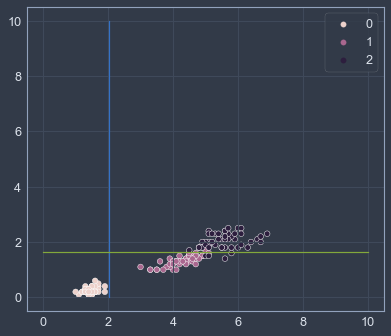

In [71]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
# sns.lineplot(x=[t_k, t_k], y=[0, 10], color='r')

for parent in [item for sub_parents in parents for item in sub_parents]:
    t_k = parent.best_J.t_k
    k = parent.best_J.k
    if k == 0:
        plt.plot([t_k, t_k], [0, 10])
    else:
        plt.plot([0, 10], [t_k, t_k])

plt.show()

In [29]:
df

,X0,X1,target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0
...,...,...,...
145,5.2,2.3,2
146,5.0,1.9,2
147,5.2,2.0,2
148,5.4,2.3,2
